In [277]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
np.random.seed(1)
plt.style.use('/home/luuk/Documents/MNRAS_stylesheet')

0.301194211912202

In [1089]:
def model(GDPshock=True,expensesshock=True,sigma = 0.005,rs=0.01):
    ## Parameters of the model
    mm = 2 #switching parameter gamma in Brock Hommes
    pstar = 0.018/12
    # the central bank's inflation target
    eprational=1 # if all agents have rational forecast of inflation this parameter is 1
    epextrapol=0 # if all agents use inflation extrapolation this parameter is 1
    a1 = 0.5 #coefficient of expected output in output equation
    a2 = 0.2 #Interest elasticity of output demand
    a3 = 0.25 #Coefficient of public expenditure in output equation
    b1 = 0.5 #b1 is coefficient of expected inflation in inflation equation
    b2 = 0.05 #b2 is coefficient of output in inflation equation
    c1 = 1.5 #c1 is coefficient of inflation in Taylor equation
    c2 = 0.5 #c2 is coefficient of output in Taylor equation
    c3 = 0.5 #interest smoothing parameter in Taylor equation
    f1 = 0.6 #Public expenditure smoothing in fiscal rule
    f2 = 0.2 #Coefficient of output in fiscal rule
    f3 = 0.03 #Coefficient of public debt in fiscal rule
    rs = rs #S.S. interest rate
    h1 = 0.8 #Coefficient of public expenditure in debt equation
    h2 = 0.6 #Coefficient of output in debt equation
    tau = 0.3 #Income tax rate
    rho=0.5 #Memory parameter
    pss = 0.01

    
    A = np.array([[1,0,a2,-a3,0],
                  [-b2,1,0,0,0],
                  [-c2,-c1,1,0,0],
                  [0,0,0,1,f3],
                  [0,0,0,0,1]])    
    B = np.array([[a1,a2,0,0,0],
                  [0,b1,0,0,0],
                  [0,0,0,0,0],
                  [0,0,0,0,0],
                  [0,0,0,0,0]])
    C = np.array([0,0,-c1,0,0])
    D = np.array([[1-a1,0,0,0,0],
                  [0,1-b1,0,0,0],
                  [0,0,c3,0,0],
                  [-f2,0,0,f1,0],
                  [-h2*tau*(1+rs),-(1+rs),1,h1*(1+rs),(1+rs)]])
    T = 380
    TI = 300
    K = 50
    #length of period to compute divergence
    sigma = np.ones(5)*np.array([2.5,1,4,1,1])*sigma
    epfs=pstar
    #forecast inflation targeters
    p = np.zeros(T)
    y = np.zeros(T)
    plagt = np.zeros(T)
    ylagt = np.zeros(T)
    r = np.zeros(T)
    epf = np.zeros(T)
    epc = np.zeros(T)
    ep = np.zeros(T)
    ey = np.zeros(T)
    CRp = np.zeros(T)
    FRp = np.zeros(T)
    alfapt = np.zeros(T)
    eyfunt = np.zeros(T)
    CRy = np.zeros(T)
    FRy = np.zeros(T)
    alfayt = np.zeros(T)
    anspirits = np.zeros(T)
    g = np.zeros(T) #government expenditures
    d = np.zeros(T) #deltas
    epsilont = np.zeros(T)
    etat = np.zeros(T)
    ut = np.zeros(T)
    nut = np.zeros(T)
    psit = np.zeros(T)
    
    GDP = 815

    #################################################
    #heuristic model
    #################################################
    alfap=0.5
    alfay=0.5
    K1=K+1

    for t in range(1,T):
        epsilont[t]=rho*epsilont[t-1]+sigma[0]*np.random.randn()#shocks in output equation [demand shock]
        etat[t]=rho*etat[t-1]+0.1*sigma[1]*np.random.randn()#shocks in inflation equation [supply shock]
        ut[t]=rho*ut[t-1]+sigma[2]*np.random.randn()#shocks in Taylor rule [interest rate shock]
        nut[t]=rho*nut[t-1]+sigma[3]*np.random.randn()
        psit[t]=rho*psit[t-1]+sigma[4]*np.random.randn()
        
        

        if expensesshock:
            nut[312:322] = 0.07
        if GDPshock:
            epsilont[312:316] = -0.1
        
        epsilon=epsilont[t]
        eta=etat[t]
        u=ut[t]
        nu = nut[t]
        psi = psit[t]
        
        
        shocks = np.array([epsilon,eta,u,nu,psi])
        epcs=p[t-1]
        if eprational==1:
            epcs=pstar

        eps=alfap*epcs+(1-alfap)*epfs
        if epextrapol==1:
            eps=p[t-1]
        # eps is expected inflation in next period
        eychar=y[t-1]
        eyfun=0+1/2
        eyfunt[t]=eyfun
        eys=alfay*eychar+(1-alfay)*eyfun
        forecast=np.array([eps, eys,0,0,0]) # expected inflation, expected y t+1
        ylag=y[t-1]
        plag=p[t-1]
        rlag=r[t-1]
        glag=g[t-1]
        dlag=d[t-1]
        lag=np.array([ylag,plag,rlag,glag,dlag])
        
        Z = np.dot(np.linalg.inv(A),(np.dot(B,forecast)+C*pstar+np.dot(D,lag)+shocks))

        
        y[t]=Z[0]
        p[t]=Z[1]
        r[t]=Z[2]
        g[t]=Z[3]
        d[t]=Z[4]
        #r[t]= (1-c3)*(c1*(p[t])+c2*y[t])+c3*rlag+u
        #if square==1
        #    r[t]=c1*[p[t]]^2+c2*y[t]+c3*r[t-1]+u
        #end
        plagt[t]=p[t-1]
        ylagt[t]=y[t-1]
        CRp[t]=rho*CRp[t-1]-(1-rho)*(epcs-p[t])**2
        FRp[t]=rho*FRp[t-1]-(1-rho)*(epfs-p[t])**2
        CRy[t]=rho*CRy[t-1]-(1-rho)*(eychar-y[t])**2
        FRy[t]=rho*FRy[t-1]-(1-rho)*(eyfun-y[t])**2

        alfap=np.exp(mm*CRp[t])/(np.exp(mm*CRp[t])+np.exp(mm*FRp[t]))
        alfay=np.exp(mm*CRy[t])/(np.exp(mm*CRy[t])+np.exp(mm*FRy[t]))
        alfapt[t]=alfap
        alfayt[t]=alfay

    # cut off initial stuff
    y = y[TI:]-np.median(y[:TI])
    p = p[TI:]-np.median(p[:TI])
    r = r[TI:]-np.median(r[:TI])
    d = d[TI:]-np.median(d[:TI])
    g = g[TI:]-np.median(g[:TI])
    
    d = np.exp(d)-1
    
    debt = (1+d/12)*0.68*GDP
    d = (1+d/12)*0.68
    g = (1+g)*0.363* GDP
    r = (1+r)*0.5
    p = (1+p)*1.2
    y = (1+y)*GDP
    
    
    return y,p,r,d,debt,g
_=model(rs=0.08)


<ipython-input-1089-7b653051ebc7>:145: RuntimeWarning: invalid value encountered in double_scalars
  alfap=np.exp(mm*CRp[t])/(np.exp(mm*CRp[t])+np.exp(mm*FRp[t]))


In [1098]:
Nruns = 200
outputs = np.zeros((6,Nruns,80))
for i in range(Nruns):
    ret = model()
    outputs[0,i,:] = ret[0]
    outputs[1,i,:] = ret[1]
    outputs[2,i,:] = ret[2]
    outputs[3,i,:] = ret[3]
    outputs[4,i,:] = ret[4]
    outputs[5,i,:] = ret[5]

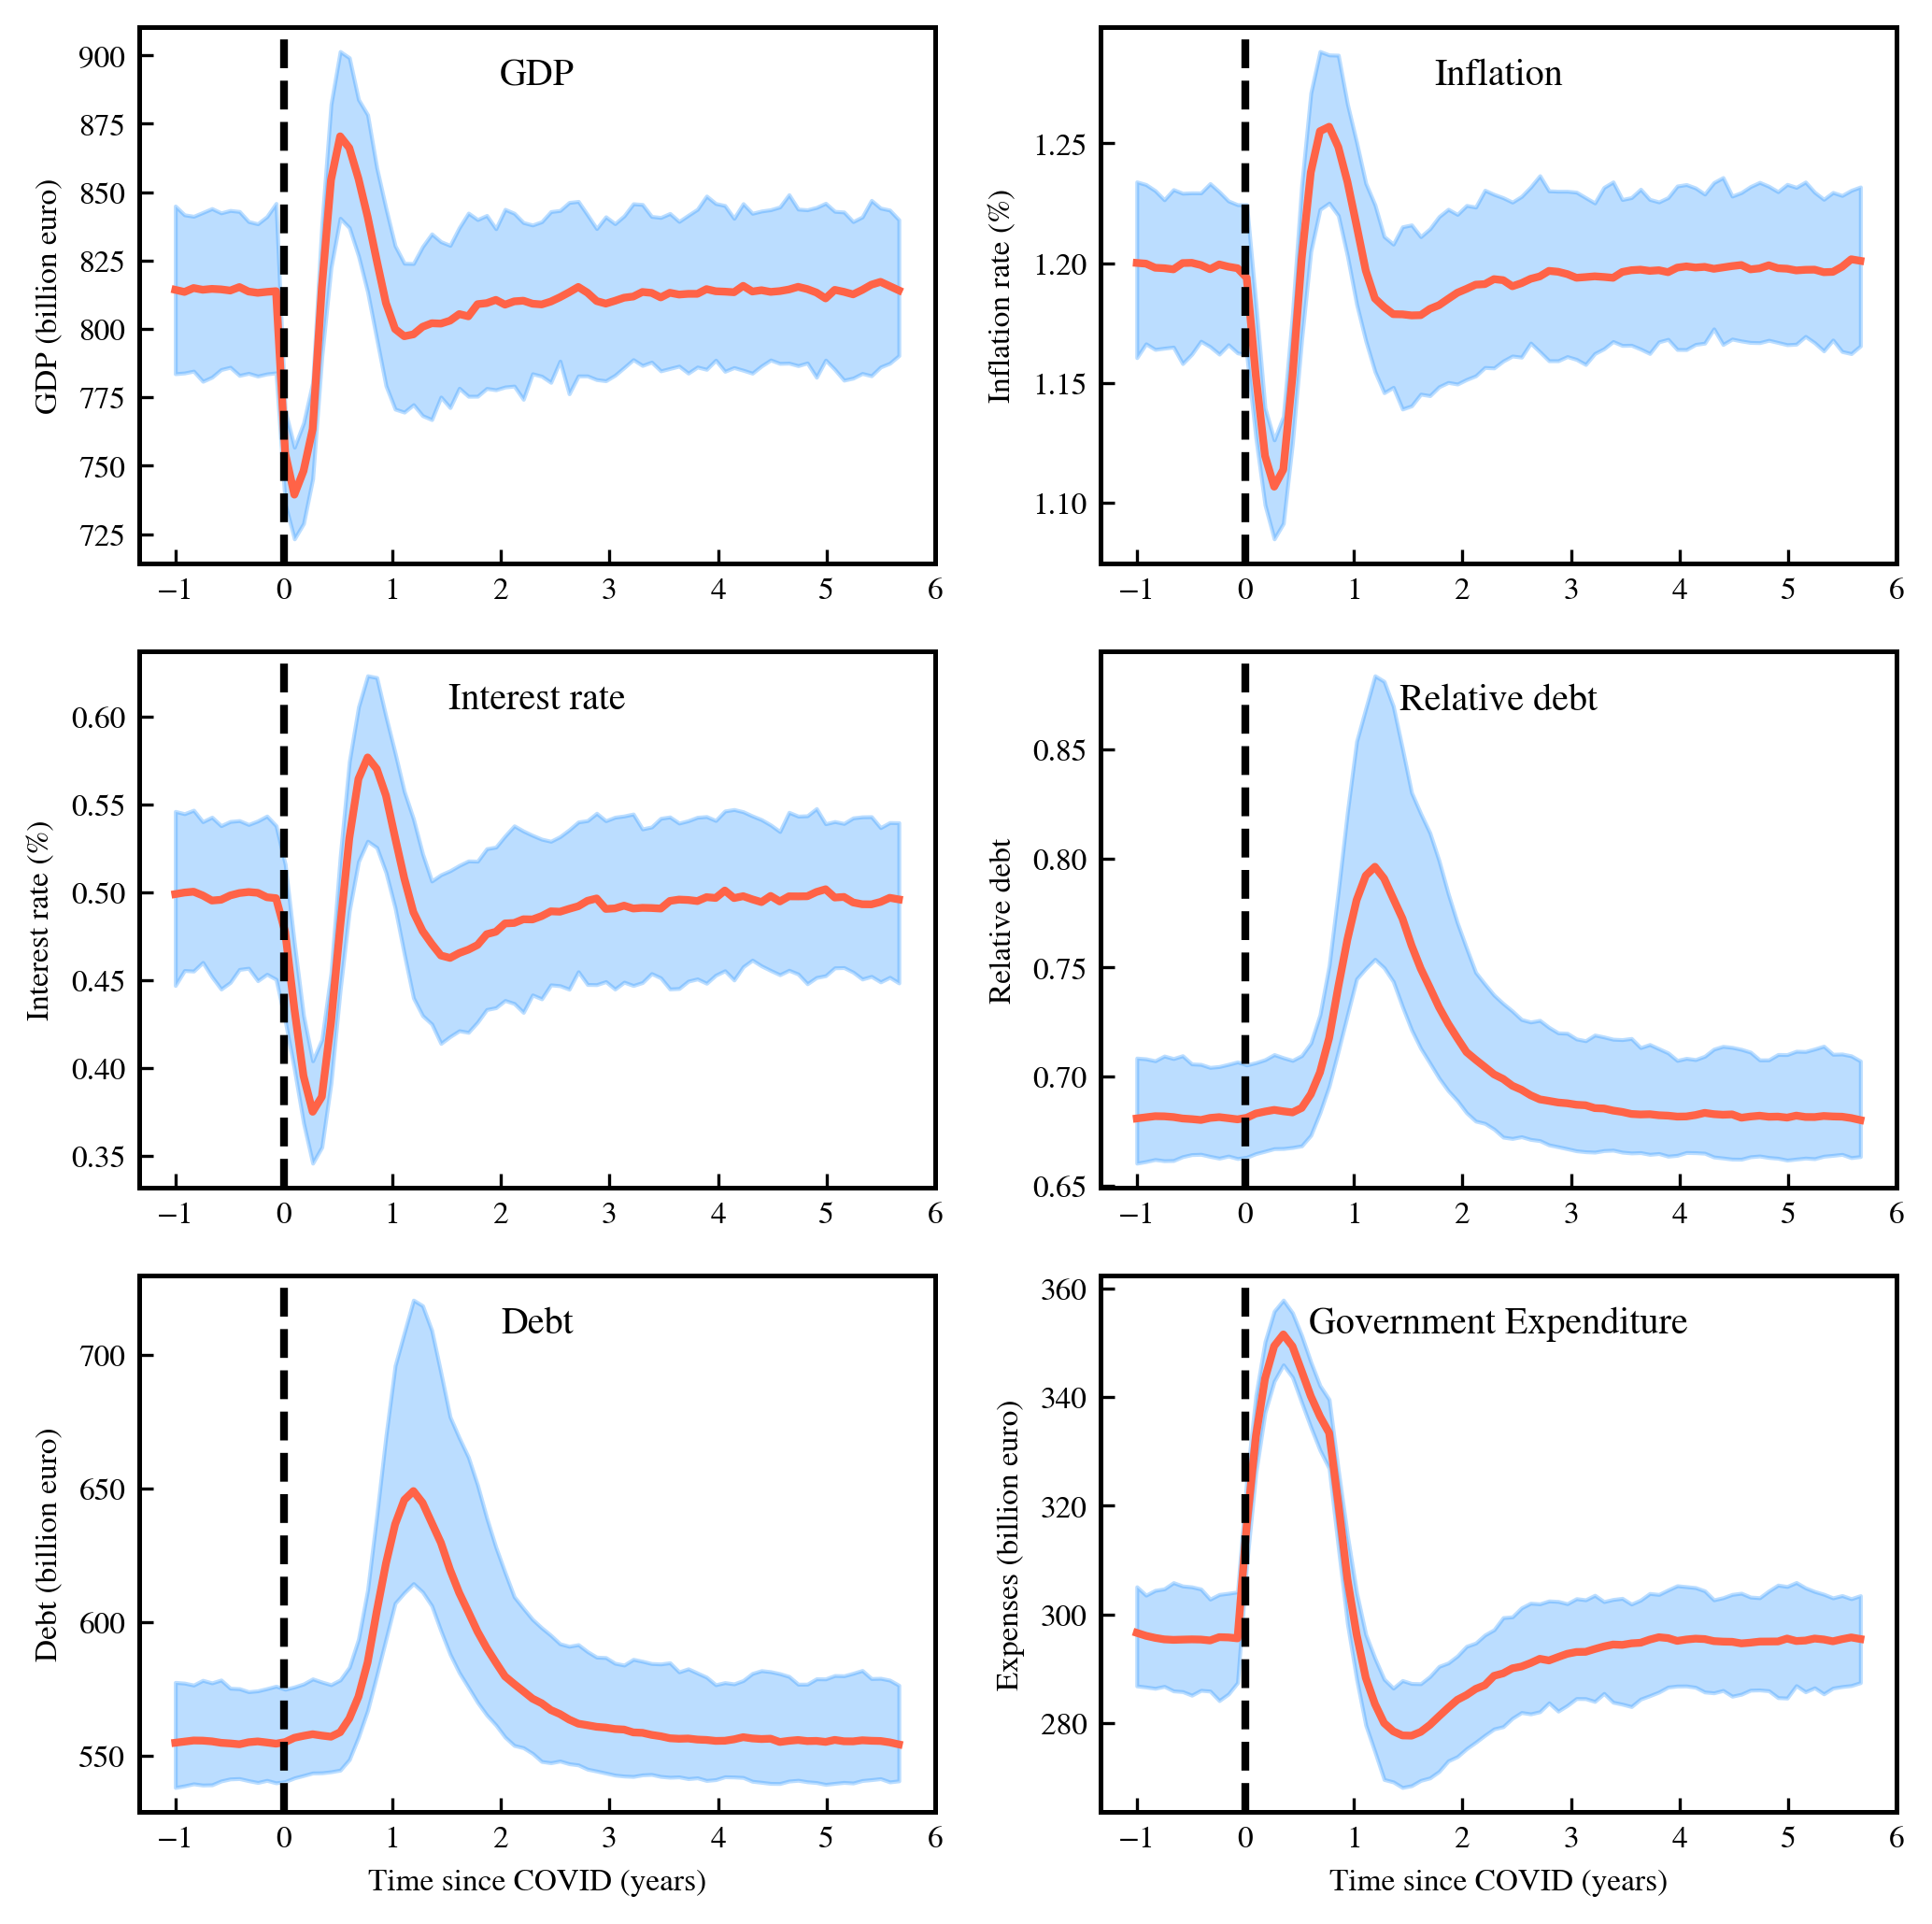

In [1099]:
def plot_impulses(outputs):
    medians = np.array([np.median(w,axis=0) for w in outputs])
    upper_quartile = np.array([np.percentile(w,q=97.5,axis=0) for w in outputs])
    lower_quartile = np.array([np.percentile(w,q=2.5,axis=0) for w in outputs])
    y,p,r,d,debt,g = medians
    y_l,p_l,r_l,d_l,debt_l,g_l = lower_quartile
    y_u,p_u,r_u,d_u,debt_u,g_u = upper_quartile
    
    
    time = np.linspace(0,len(y),len(y))/12-1
    fig, [[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(7,7))
    ax1.plot(time,y,color='tomato')
    ax1.fill_between(time,y_l,y_u,alpha=0.3,color='dodgerblue')
    ax1.set_title('GDP',y=0.85)
    ax1.set_ylabel('GDP (billion euro)')
    #ax1.set_ylabel('USD')
    ax2.plot(time,p,color='tomato')
    ax2.fill_between(time,p_l,p_u,alpha=0.3,color='dodgerblue')
    ax2.set_title('Inflation',y=0.85)
    ax2.set_ylabel('Inflation rate (%)')
    ax3.plot(time,r,color='tomato')
    ax3.fill_between(time,r_l,r_u,alpha=0.3,color='dodgerblue')
    ax3.set_ylabel('Interest rate (%)')
    ax3.set_title('Interest rate',y=0.85)
    ax4.plot(time,d,color='tomato')
    ax4.set_ylabel('Relative debt')
    ax4.fill_between(time,d_l,d_u,alpha=0.3,color='dodgerblue')
    ax4.set_title('Relative debt',y=0.85)
    ax5.plot(time,debt,color='tomato')
    ax5.fill_between(time,debt_l,debt_u,alpha=0.3,color='dodgerblue')
    ax5.set_title('Debt',y=0.85)
    ax5.set_ylabel('Debt (billion euro)')
    ax6.plot(time,g,color='tomato')
    ax6.fill_between(time,g_l,g_u,alpha=0.3,color='dodgerblue')
    ax6.set_title('Government Expenditure',y=0.85)
    ax6.set_ylabel('Expenses (billion euro)')
    
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        ax.axvline(0,ls='--',color='black')
    #for ax in [ax1,ax2,ax3,ax4]:
    #    ax.set_xticklabels(['']*len(ax.get_xticks()))
    for ax in [ax5,ax6]:
        ax.set_xlabel('Time since COVID (years)')
    plt.tight_layout(pad=1.5)
    plt.savefig('dummy_impulse_responses.pdf')
    plt.show()

plot_impulses(outputs)

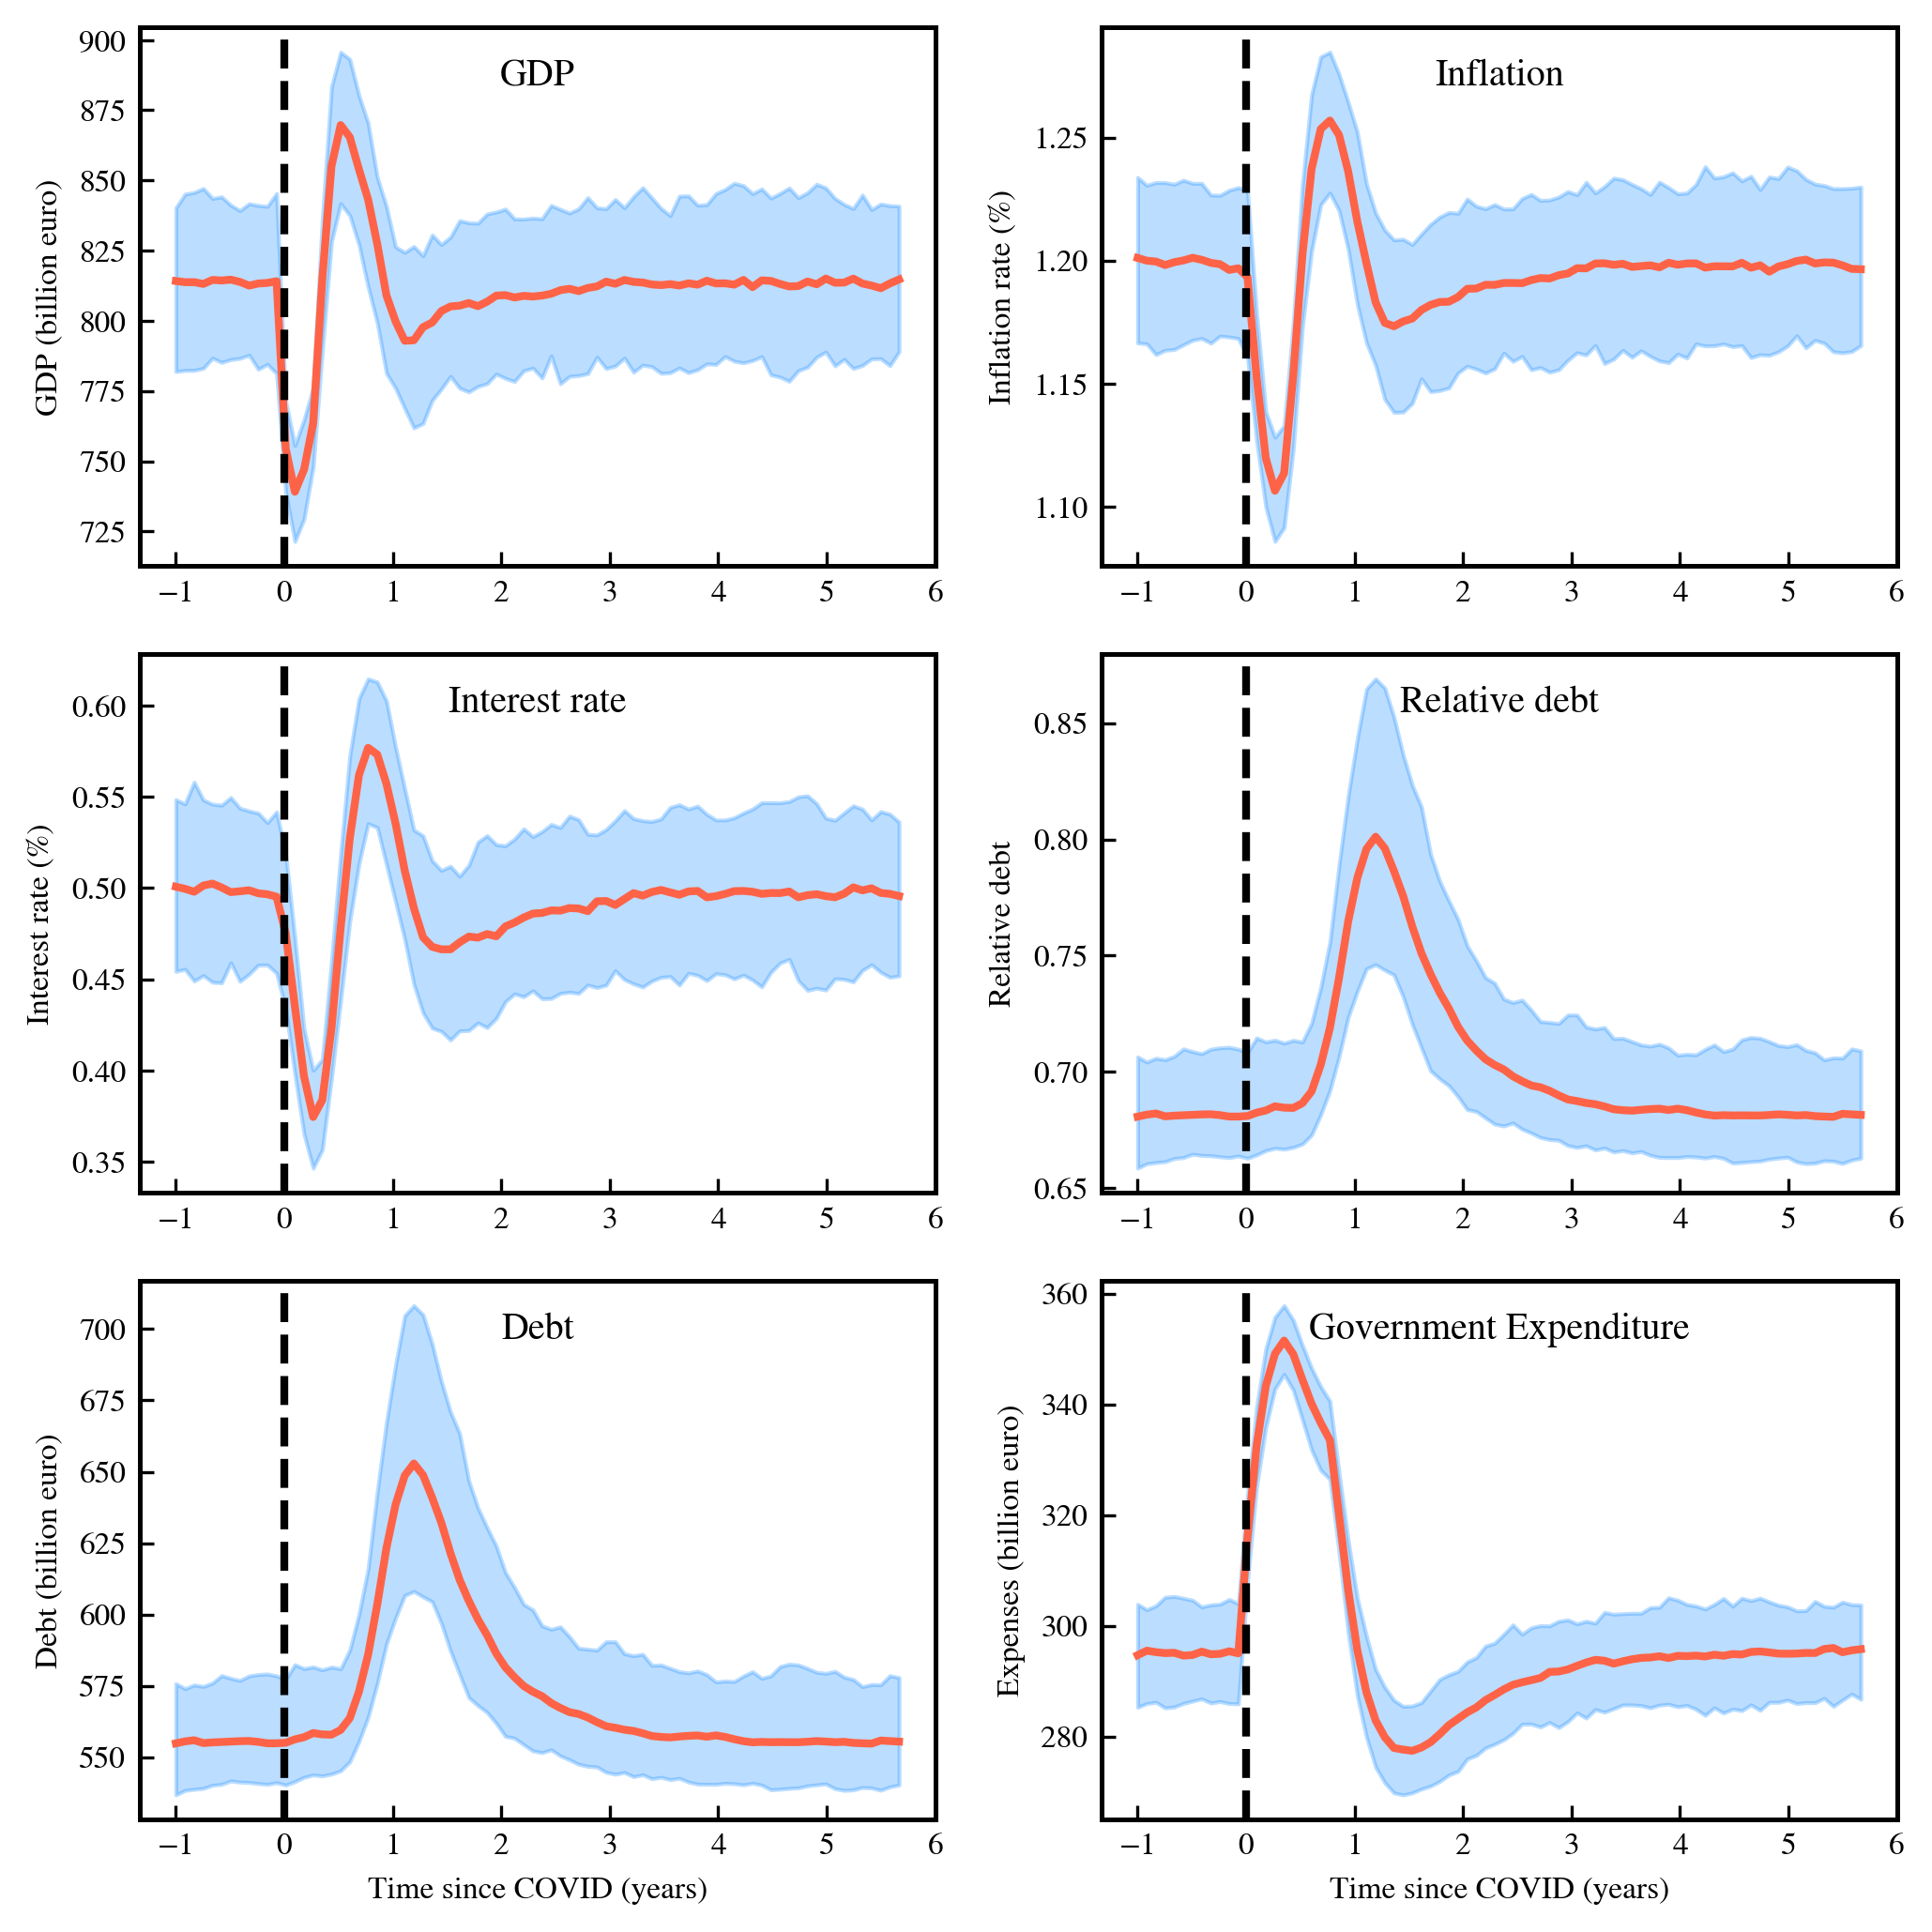

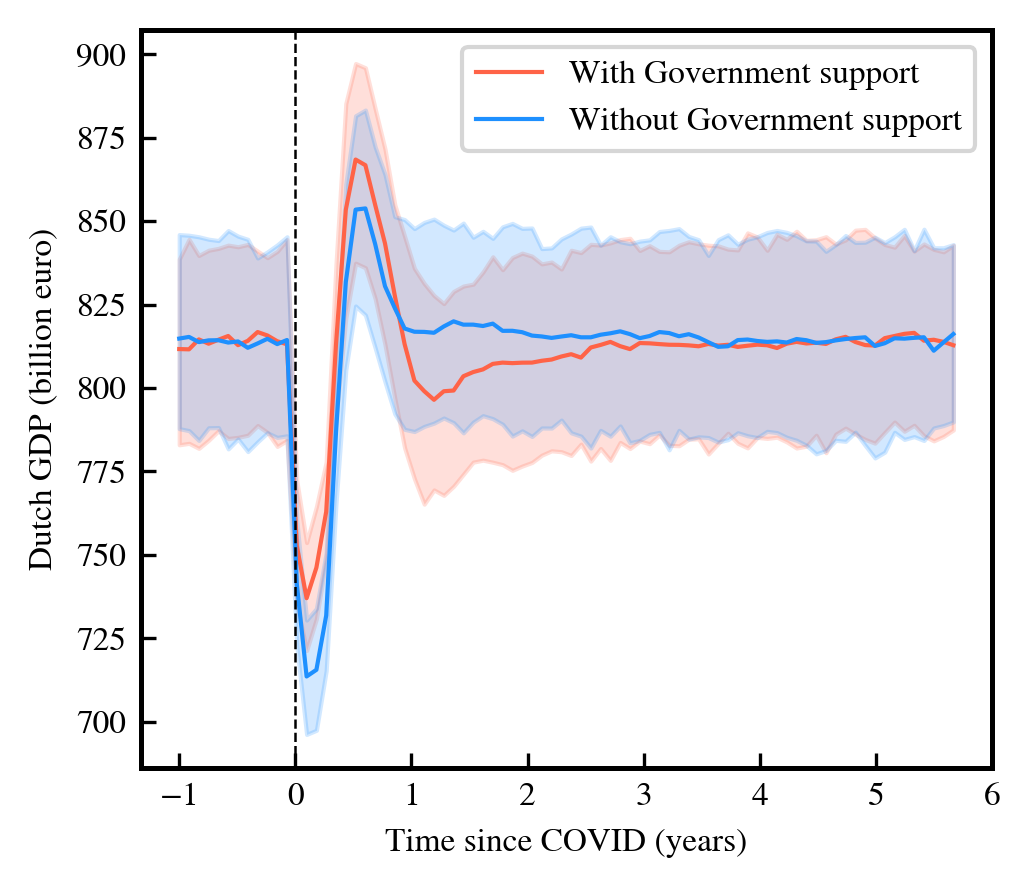

In [1059]:
def with_without_expenses():
    Nruns = 300
    outputs = np.zeros((6,Nruns,80))
    for i in range(Nruns):
        ret = model(GDPshock=True,expensesshock=False,)
        outputs[0,i,:] = ret[0]
        outputs[1,i,:] = ret[1]
        outputs[2,i,:] = ret[2]
        outputs[3,i,:] = ret[3]
        outputs[4,i,:] = ret[4]
        outputs[5,i,:] = ret[5]
    GDPwithout = np.median(outputs[0],axis=0)
    GDPwithout_u = np.percentile(outputs[0],axis=0,q=97.5)
    GDPwithout_l = np.percentile(outputs[0],axis=0,q=2.5)
    for i in range(Nruns):
        ret = model(GDPshock=True,expensesshock=True)
        outputs[0,i,:] = ret[0]
        outputs[1,i,:] = ret[1]
        outputs[2,i,:] = ret[2]
        outputs[3,i,:] = ret[3]
        outputs[4,i,:] = ret[4]
        outputs[5,i,:] = ret[5]
    GDPwith = np.median(outputs[0],axis=0)
    GDPwith_u = np.percentile(outputs[0],axis=0,q=97.5)
    GDPwith_l = np.percentile(outputs[0],axis=0,q=2.5)
    time = np.linspace(0,len(GDPwith)/12,len(GDPwith))-1
    
    plt.plot(time,GDPwith,label='With Government support',color='tomato',lw=1)
    plt.fill_between(time,GDPwith_l,GDPwith_u,color='tomato',alpha=0.2)
    plt.plot(time,GDPwithout,label='Without Government support',color='dodgerblue',lw=1)
    plt.fill_between(time,GDPwithout_l,GDPwithout_u,color='dodgerblue',alpha=0.2)
    plt.legend(frameon=True)
    plt.xlabel('Time since COVID (years)')
    plt.axvline(0,ls='--',color='black',lw=0.6)
    plt.tight_layout()
    plt.ylabel('Dutch GDP (billion euro)')
    #plt.savefig('With_without_support.pdf')
with_without_expenses()

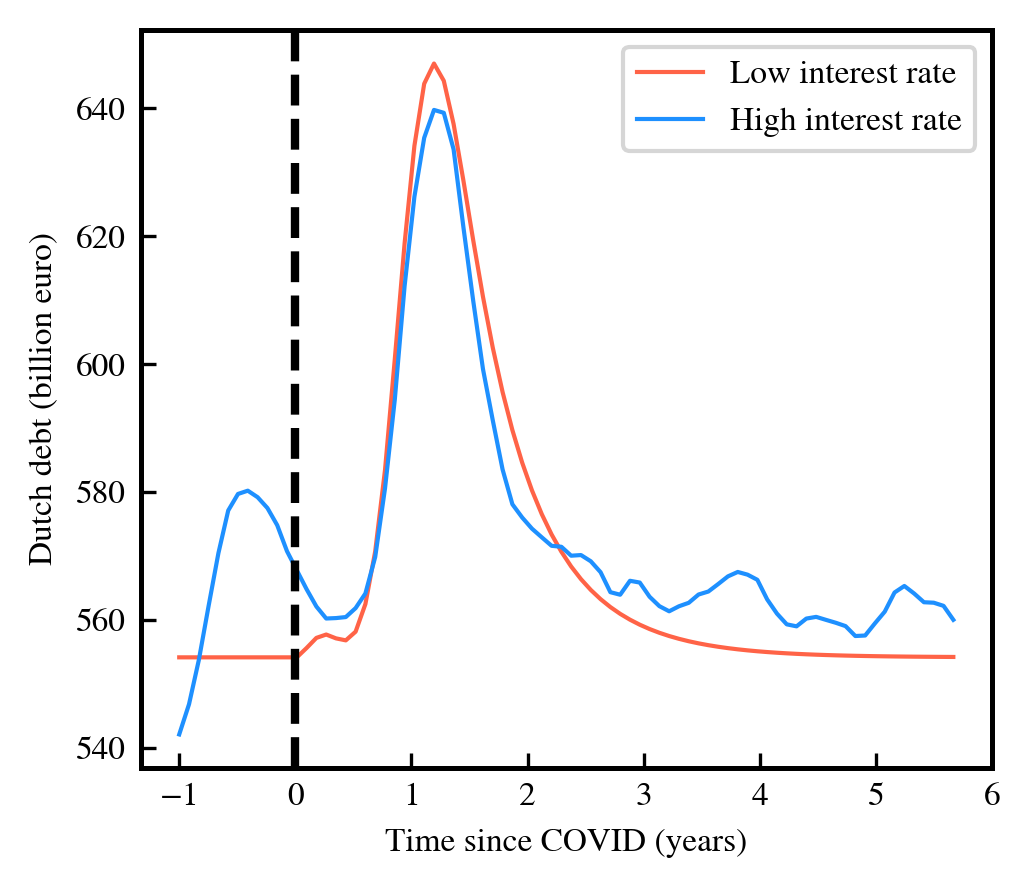

In [1071]:
def debt():
    Nruns = 100
    outputs = np.zeros((6,Nruns,80))
    for i in range(Nruns):
        ret = model(GDPshock=True,expensesshock=True,sigma=0,rs=0.01)
        outputs[0,i,:] = ret[0]
        outputs[1,i,:] = ret[1]
        outputs[2,i,:] = ret[2]
        outputs[3,i,:] = ret[3]
        outputs[4,i,:] = ret[4]
        outputs[5,i,:] = ret[5]
    debt1 = ret[4]
    outputs = np.zeros((6,Nruns,80))    
    for i in range(Nruns):
        ret = model(GDPshock=True,expensesshock=True,rs=0.01)
        outputs[0,i,:] = ret[0]
        outputs[1,i,:] = ret[1]
        outputs[2,i,:] = ret[2]
        outputs[3,i,:] = ret[3]
        outputs[4,i,:] = ret[4]
        outputs[5,i,:] = ret[5]
    debt2 = ret[4]
    time = np.linspace(0,len(debt2)/12,len(debt2))-1
    plt.plot(time,debt1,label='Low interest rate',color='tomato',lw=1)
    plt.plot(time,debt2,label='High interest rate',color='dodgerblue',lw=1)
    plt.legend(frameon=True)
    plt.xlabel('Time since COVID (years)')
    plt.axvline(0,ls='--',color='black')
    plt.tight_layout()
    plt.ylabel('Dutch debt (billion euro)')
    #plt.savefig('With_without_support.pdf')
debt()

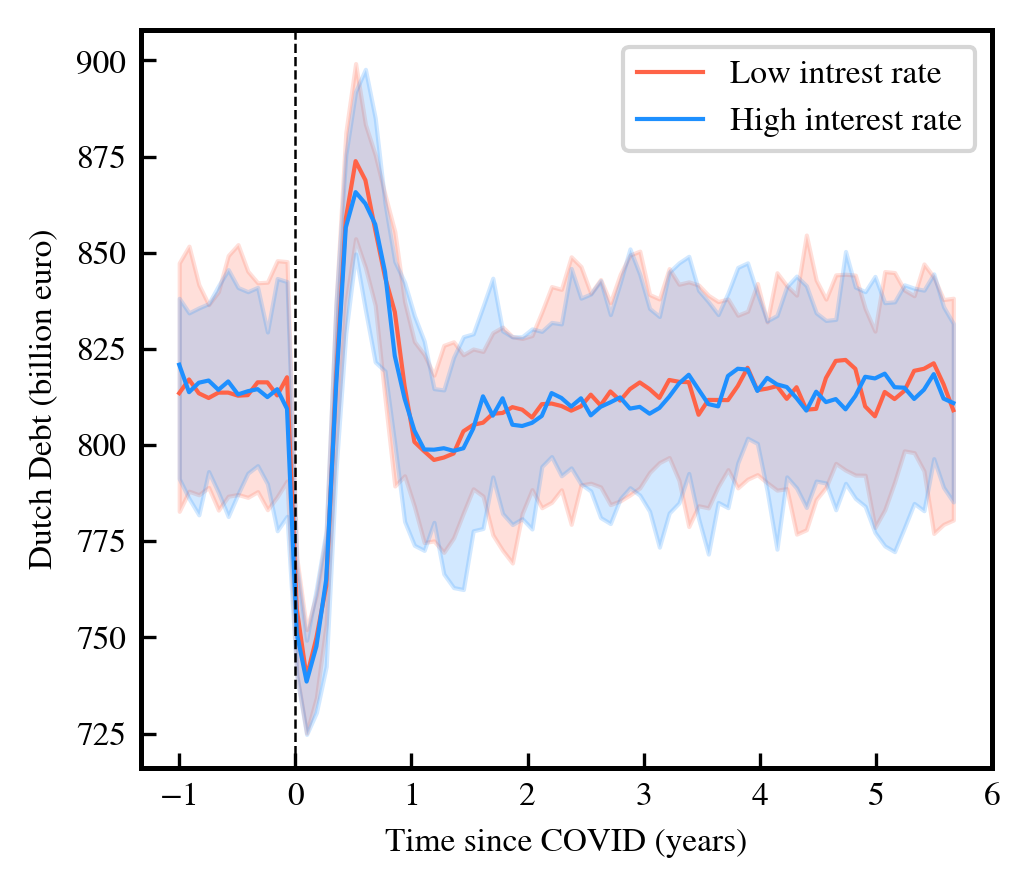

In [1084]:
def debt():
    Nruns = 30
    outputs = np.zeros((6,Nruns,80))
    for i in range(Nruns):
        ret = model(GDPshock=True,expensesshock=True,rs=0.01)
        outputs[0,i,:] = ret[0]
        outputs[1,i,:] = ret[1]
        outputs[2,i,:] = ret[2]
        outputs[3,i,:] = ret[3]
        outputs[4,i,:] = ret[4]
        outputs[5,i,:] = ret[5]
    debt1 = np.median(outputs[0],axis=0)
    debt1_u = np.percentile(outputs[0],axis=0,q=97.5)
    debt1_l = np.percentile(outputs[0],axis=0,q=2.5)
    for i in range(Nruns):
        ret = model(GDPshock=True,expensesshock=True,rs=0.01)
        outputs[0,i,:] = ret[0]
        outputs[1,i,:] = ret[1]
        outputs[2,i,:] = ret[2]
        outputs[3,i,:] = ret[3]
        outputs[4,i,:] = ret[4]
        outputs[5,i,:] = ret[5]
    debt2 = np.median(outputs[0],axis=0)
    debt2_u = np.percentile(outputs[0],axis=0,q=97.5)
    debt2_l = np.percentile(outputs[0],axis=0,q=2.5)
    
    
    time = np.linspace(0,len(debt2)/12,len(debt2))-1
    
    plt.plot(time,debt1,label='Low intrest rate',color='tomato',lw=1)
    plt.fill_between(time,debt1_l,debt1_u,color='tomato',alpha=0.2)
    plt.plot(time,debt2,label='High interest rate',color='dodgerblue',lw=1)
    plt.fill_between(time,debt2_l,debt2_u,color='dodgerblue',alpha=0.2)
    plt.legend(frameon=True)
    plt.xlabel('Time since COVID (years)')
    plt.axvline(0,ls='--',color='black',lw=0.6)
    plt.tight_layout()
    plt.ylabel('Dutch Debt (billion euro)')
    #plt.savefig('With_without_support.pdf')
debt()